<a href="https://colab.research.google.com/github/peter-adepoju/AIMS-Courses/blob/main/sbi_week03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation and Inference for Neuroscience
## Exercises Week 3: Parameter inference for simulators in neuroscience

The notebook below contains the exercises for week 3.
The exercises are designed to follow the lecture material and do not need deep knowledge of python to be solved.

There are two types of exercises:
- **Tasks**: Where you need to write code, i.e. "implement a function that does X".
- **Questions**: Where you need to answer questions using the code you wrote. For example "vary the inputs and interpret the results", will require you to provide one or more plots together with your answer. To answer the questions you can use Markdown cells.

All necessary dependencies are imported in the first cell and you should not need to import anything else. In addition, we also provide some helper functions that can be used to help you answering the tasks. When solving the tasks, feel free to change the provided function signatures and code as you see fit. However, we recommend sticking with the provided signatures as they reflect common conventions and will make it easier to add additional functionality during the exercise. Type hints are provided for the function signatures and the arguments and each task should only require a few lines of code.

In [ ]:
# configure jax to use 64bit precision and cpu
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [ ]:
# add the project root to the python path
import sys
sys.path.append("..")

# import the necessary dependencies
import matplotlib.pyplot as plt
import numpy as np
import optax
import torch
import jax
from jax import numpy as jnp
from jax import jit, vmap, value_and_grad

# jaxley imports
import jaxley as jx
from jaxley.channels import HH
from jaxley.stimulus import step_current
from jaxley.optimize.utils import l2_norm
from jaxley.optimize.transforms import SigmoidTransform, ParamTransform

# sbi imports
from sbi.utils import BoxUniform
from sbi.inference import SNPE
from sbi.analysis import pairplot

# Typing imports
from typing import Callable, Union, Optional, Tuple

In [ ]:
# utils
def plot_observation(
    t_obs: Union[jnp.ndarray, torch.tensor],
    v_obs: Union[jnp.ndarray, torch.tensor],
    i_obs: Optional[Union[jnp.ndarray, torch.tensor]] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """Plot the observed voltage and stimulus.

    If stimulus is provided it will create a figure with 2 axes, otherwise it will create a figure with 1 axis.

    Args:
        t_obs: The time points of the observed voltage and stimulus (ms).
        v_obs: The observed voltage (mV).
        i_obs: The observed stimulus (nA).

    Returns:
        fig: The figure.
        ax: The axes.
    """
    num_rows = 2 if i_obs is not None else 1
    height_ratios = [3, 1] if i_obs is not None else [1]
    fig, ax = plt.subplots(
        num_rows,
        1,
        figsize=(10, 5),
        sharex=True,
        gridspec_kw={"height_ratios": height_ratios},
    )
    if num_rows == 1:
        ax = [ax]
    ax[0].plot(t_obs, v_obs, c="k")
    ax[0].set_xlabel("t (ms)")
    ax[0].set_ylabel("V (mV)")
    if i_obs is not None:
        ax[1].plot(t_obs, i_obs, c="k")
        ax[1].set_xlabel("t (ms)")
        ax[1].set_ylabel("stimulus (nA)")
    return fig, ax

def make_plot(
    t_est: Union[jnp.ndarray, torch.tensor],
    v_est: Union[jnp.ndarray, torch.tensor],
    t_obs: Optional[Union[jnp.ndarray, torch.tensor]] = None,
    v_obs: Optional[Union[jnp.ndarray, torch.tensor]] = None,
    i_obs: Optional[Union[jnp.ndarray, torch.tensor]] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """Plot the estimated voltage and stimulus (along with the observed data if provided).

    Args:
        t_est: The time points of the estimated voltage (ms).
        v_est: The estimated voltage (mV).
        t_obs: The time points of the observed voltage (ms).
        v_obs: The observed voltage (mV).
        i_obs: The observed stimulus (nA).
    """
    if t_obs is not None:
        fig, ax = plot_observation(t_obs, v_obs, i_obs)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax = [ax]
    ax[0].plot(t_est, v_est, c="r", alpha=0.5)
    ax[0].set_xlabel("t (ms)")
    ax[0].set_ylabel("V (mV)")
    return fig, ax

# Infer parameters of a single compartment HH model

In week 1 we have learned how to simulate neural dynamics using the Hodgkin-Huxley model, i.e. going from parameters to observations. We call this the forward problem.
In week 2 on the otherhand, you were introduced to methods that solve the so called inverse problem, i.e. going from observations to parameters.
Now we will put these two together and see how we can combine simulation and inference methods to infer the parameters of a Hodgkin-Huxley model from a measured voltage trace.

Lets start by importing and looking at the data, before attempting to infer the model parameters at different levels of sophistication.

Sampling interval:  0.25 ms
Max. time:  100.0 ms
Stimulus amplitude:  0.01 nA
Stimulus (end | duration | onset):  90.00 | 80.00 | 10.00 ms


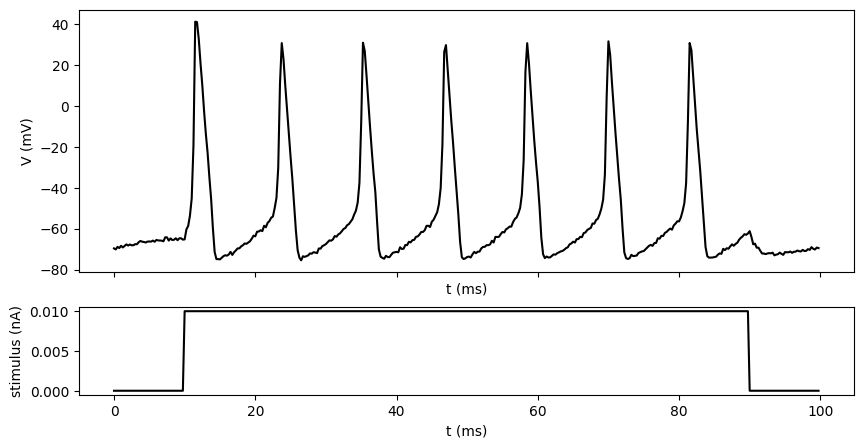

In [ ]:
# load observation (note that we convert the data to a jax array)
t_obs, v_obs, stim_obs = jnp.array(np.loadtxt("../data/observation.csv", unpack=True))

# stimulus information
sampling_interval = t_obs[1] - t_obs[0]
stim_amp = jnp.max(stim_obs)

# Using nonzero returns a tuple; we select the first dimension indices and then extract onset/end
stim_indices = jnp.nonzero(stim_obs)[0]
stim_onset = t_obs[stim_indices[0]]
stim_end = t_obs[stim_indices[-1]] + sampling_interval
stim_dur = stim_end - stim_onset
t_max = t_obs[-1] + sampling_interval

print("Sampling interval: ", sampling_interval, "ms")
print("Max. time: ", t_max, "ms")
print("Stimulus amplitude: ", stim_amp, "nA")
print("Stimulus (end | duration | onset): ", f"{stim_end:.2f} | {stim_dur:.2f} | {stim_onset:.2f} ms")

# plot the observation
plot_observation(t_obs, v_obs, i_obs=stim_obs)
plt.show()

## Hand-tuning
Arguably the most simple approach to solve the inverse problem is just by "trial and error" or hand tuning the parameters. How difficult this can already be for just 3 parameters, we will explore in the following:

### Tasks
- Implement a simulator for a single compartment HH model in `jaxley`
    - For details see the [documentation](https://jaxley.readthedocs.io/en/latest/index.html)
- hand-tune (manually vary) the different conductances $g_{Na}$, $g_{K}$, $g_{leak}$ to fit a single compartment HH model to the measured voltage trace.
- plot the results

### Questions
- How do you assess the quality of the fit, i.e. what (characteristics) do you look for?
- What are ways to quantify this?

_Note: don't forget to set the initial conditions_

In [ ]:
# Set up the simulation

# NOTE: Keep in mind that the stepsize of the solver is 1/10th of the sampling interval of our experimental data!
dt = 0.025

# define the stimulus using parameters from the observation (stim_onset, stim_dur, stim_amp, t_max)
stimulus = step_current(
    i_delay=stim_onset,  # time when the stimulus starts
    i_dur=stim_dur,      # duration of the stimulus
    i_amp=stim_amp,      # amplitude of the stimulus
    delta_t=dt,          # solver stepsize
    t_max=t_max          # total simulation time
)
# create a time vector with steps of dt up to t_max
ts = jnp.arange(0, t_max, dt)

# create a single compartment HH model:
#   1. Create a compartment
#   2. Insert the Hodgkin-Huxley channel
#   3. Add the stimulus to the compartment
#   4. Record the voltage trace ("v")
comp = jx.Compartment()
comp.insert(HH())
comp.stimulate(stimulus)
comp.record("v")

# set the initial conditions (if needed, you can modify default initial states here)
# For this example, we assume the defaults provided by the HH channel are acceptable.

# define a simulator that integrates the model with given parameters
@jit
def simulate(params: dict[str, jnp.ndarray]) -> jnp.ndarray:
    """Simulate the HH model for the given parameters.

    Since we run this function many times, we use @jit to compile it for speed.

    Args:
        params: The parameters of the HH model.

    Returns:
        v: The voltage trace with a length matching ts.
    """
    # update the model's parameters (e.g. channel conductances or other properties)
    pstate = None
    for key, value in params.items():
        pstate = comp.data_set(key, value, pstate)

    # integrate the model over time using the defined time step dt
    v = jx.integrate(comp, param_state=pstate, delta_t=dt)
    return v[:, :len(ts)]  # ensure that the voltage trace matches the length of ts


Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


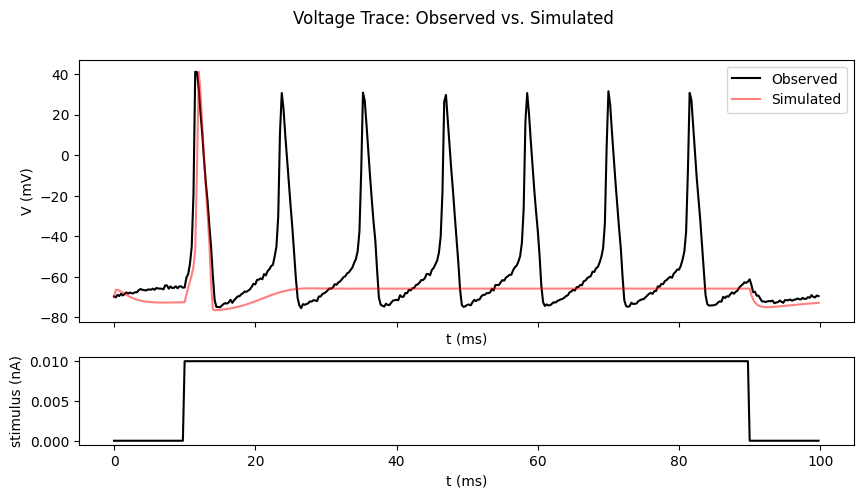

In [ ]:
# Define the parameter bounds
lb_vals = {"HH_gNa": 1e-3, "HH_gK": 1e-3, "HH_gLeak": 1e-5}
ub_vals = {"HH_gNa": 1.0, "HH_gK": 1.0, "HH_gLeak": 1e-3}
bounds = {k: (lb, ub) for k, (lb, ub) in zip(lb_vals.keys(), zip(lb_vals.values(), ub_vals.values()))}

# Hand-tune the parameters (using jax arrays; adjust to plain floats if needed)
param_guess = {"HH_gNa": jnp.array([0.3]), "HH_gK": jnp.array([0.2]), "HH_gLeak": jnp.array([0.0001])}

# Run the simulation using the parameter guess.
v_guess_full = simulate(param_guess)
v_guess = v_guess_full[0] if v_guess_full.ndim > 1 else v_guess_full

# Downsample the simulated voltage trace to match the observed data length.
# For example, if the simulation produces 10 times as many points as observed:
downsample_factor = len(v_guess) // len(t_obs)
v_guess_ds = v_guess[::downsample_factor]

# Create the plot comparing observed vs. simulated voltage traces.
fig, ax = make_plot(t_obs, v_guess_ds, t_obs, v_obs, stim_obs)

# Add a legend to the voltage subplot (ax[0])
ax[0].lines[0].set_label("Observed")  # Black line (observed)
ax[0].lines[1].set_label("Simulated")  # Red line (simulated)
ax[0].legend()

# Add a title to the figure
fig.suptitle("Voltage Trace: Observed vs. Simulated")

# Display the plot
plt.show()

## Random / Grid search
While hand-tuning is a very simple method that can work for a few parameters, you should have noticed that this is already tricky for just 3 parameters and it will quickly become infeasible for more complex models and larger parameter spaces. Therefore we will explore a still simple, but more systematic approach: random / grid search.

### Tasks
- Implement a mean absolute error loss
- Implement **either** a random **or** a grid search to find suitable parameters
- Plot your top 10 results as quantified by their mean absolute error

### Questions
- Are the results what you expected? Why / Why not?
- What are different ways in which you could improve the results?

In [ ]:
# parallelize the simulation (for more details see https://docs.jax.dev/en/latest/_autosummary/jax.vmap.html)
# this way you can input an entire batch of parameters rather than having to loop over them
parallel_simulate = vmap(simulate)

# define an error / distance function
def mean_abs_err(v_est: jnp.ndarray, v_true: jnp.ndarray) -> jnp.ndarray:
    """
    Compute the mean absolute error between the estimated and observed voltage trace.

    Args:
        v_est: The estimated voltage trace (1D array or batch of traces).
        v_true: The true voltage trace (1D array).

    Returns:
        err: The mean absolute error.
    """
    return jnp.mean(jnp.abs(v_est - v_true), axis=-1)

NameError: name 'vmap' is not defined

In [ ]:
# sample a batch of parameters (randomly or on a grid)
lb_vals = {"HH_gNa": 1e-3, "HH_gK": 1e-3, "HH_gLeak": 1e-5}
ub_vals = {"HH_gNa": 1.0, "HH_gK": 1.0, "HH_gLeak": 1e-3}
# Random search
num_samples = 10_000
key = jax.random.PRNGKey(42)
key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)

HH_gNa_samples = jax.random.uniform(subkey1, shape=(num_samples,),
                                minval=lb_vals["HH_gNa"], maxval=ub_vals["HH_gNa"])
HH_gK_samples  = jax.random.uniform(subkey2, shape=(num_samples,),
                                minval=lb_vals["HH_gK"],  maxval=ub_vals["HH_gK"])
HH_gLeak_samples = jax.random.uniform(subkey3, shape=(num_samples,),
                                  minval=lb_vals["HH_gLeak"], maxval=ub_vals["HH_gLeak"])

# Create a batch of parameter dictionaries (each parameter is reshaped to (num_samples, 1))
params_batch = {
    "HH_gNa": HH_gNa_samples[:, None],
    "HH_gK": HH_gK_samples[:, None],
    "HH_gLeak": HH_gLeak_samples[:, None]
}

NameError: name 'jax' is not defined

In [ ]:
# simulate the batch of parameters
v_samples_batch = parallel_simulate(params_batch)
# Extract the voltage trace from the first (or only) recording: shape becomes (num_samples, n_timepoints)
v_samples = v_samples_batch[:, 0, :]

# Downsample simulated voltage traces to match the observed trace length.
# For example, if v_samples has 4000 time points and v_obs has 400, the downsample factor is 10.
downsample_factor = v_samples.shape[1] // v_obs.shape[0]
v_samples_ds = v_samples[:, ::downsample_factor]

# compute the mean absolute error (each simulation is compared to the observed voltage trace, v_obs)
err = mean_abs_err(v_samples_ds, v_obs)

# get the top 10 results (indices with the lowest error)
top_indices = jnp.argsort(err)[:10]

NameError: name 'parallel_simulate' is not defined

In [ ]:
# plot the top 10 results and compare them with the observation
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()

for i, idx in enumerate(top_indices):
    # Use the downsampled simulation trace
    sim_trace = v_samples_ds[idx]
    err_val = err[idx]
    axes[i].plot(t_obs, v_obs, label="Observed", color="black")
    axes[i].plot(t_obs, sim_trace, label="Simulated", color="red", alpha=0.7)
    axes[i].set_title(f"Error: {err_val:.3f}")
    axes[i].set_xlabel("Time (ms)")
    axes[i].set_ylabel("Voltage (mV)")
    axes[i].legend(fontsize=8)

plt.suptitle("Top 10 Simulated Voltage Traces (Random Search)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

NameError: name 'plt' is not defined

## Rejection ABC
While using random and grid searches to sample the parameter space can yield good results, they struggle to deal with uncertainty and noisy data. Bayesian inference tries to alleviate this by infering a posterior distribution, rather than a point estimate. Unfortunately, most simulators have intractable likelihood functions however and hence we can only approximately do Bayesian inference (Approximate Bayesian Computation, ABC). One method to do this is called rejection ABC, where we approximate the posterior using samples from the simulator.

### Tasks
- Implement a rejection ABC sampler using the mean squared error as a distance metric
- Sample the parameter space
- Plot your top 10 parameter samples. Compare them to the previous best samples
- Play around with the threshold to see how it affects the results

### Questions
- Are the results what you expected? Why / Why not?
- What are different ways in which you could improve the results?

_Note you can use the `mean_abs_err` function you defined before._

In [ ]:
bounds = {k: (lb, ub) for k, (lb, ub) in zip(lb_vals.keys(), zip(lb_vals.values(), ub_vals.values()))}

In [ ]:
from typing import Callable, Tuple

# implement the rejection ABC sampler
def rejection_abc(num_samples: int, threshold: float,
                  distance_fn: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray] = mean_abs_err
                 ) -> Tuple[dict[str, jnp.ndarray], jnp.ndarray, jnp.ndarray]:
    """Rejection ABC sampler.

    Args:
        num_samples: The number of samples to draw.
        threshold: The threshold for the distance.
        distance_fn: The distance function.

    Returns:
        accepted_params: A dictionary of accepted parameter samples.
        accepted_distances: The distances of the accepted samples.
        accepted_v: The simulated voltage traces corresponding to accepted samples.
    """
    # Sample parameters from the prior
    rng = jax.random.split(jax.random.PRNGKey(0), len(bounds))
    samples = {k: jax.random.uniform(sub_rng, (num_samples,), minval=lb, maxval=ub)
               for sub_rng, (k, (lb, ub)) in zip(rng, bounds.items())}

    # Prepare batch for simulation: reshape to (num_samples, 1)
    params_batch = {k: v[:, None] for k, v in samples.items()}

    # Simulate for all parameter samples
    v_samples_batch = parallel_simulate(params_batch)
    # Extract voltage trace from the first (or only) recording: shape (num_samples, n_timepoints)
    v_samples = v_samples_batch[:, 0, :]

    # Downsample simulated traces to match the observed trace length
    downsample_factor = v_samples.shape[1] // v_obs.shape[0]
    v_samples_ds = v_samples[:, ::downsample_factor]

    # Calculate distances for each simulation (result shape: (num_samples,))
    distances = distance_fn(v_samples_ds, v_obs)

    # Select samples with distances below the threshold
    accepted_indices = jnp.where(distances < threshold)[0]
    accepted_params = {k: v[accepted_indices] for k, v in samples.items()}
    accepted_distances = distances[accepted_indices]

    return accepted_params, accepted_distances, v_samples_ds[accepted_indices]


In [ ]:
# Run rejection ABC
num_samples = 10_000
threshold = 13  # Adjust this threshold based on your data and desired acceptance rate
accepted_params, accepted_distances, accepted_v = rejection_abc(num_samples, threshold)

# Sort accepted samples by distance (lowest first)
sorted_indices = jnp.argsort(accepted_distances)
top_indices = sorted_indices[:10]  # Get the top 10 best-fitting samples

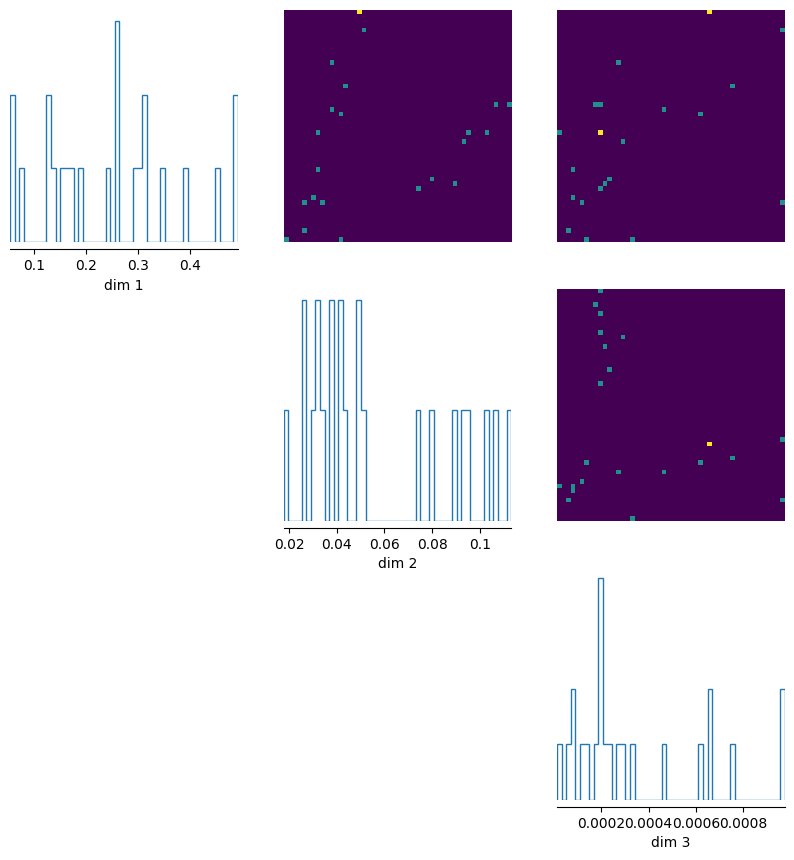

In [ ]:
import torch
import numpy as np
from sbi.analysis import pairplot

# Convert accepted parameter samples to a torch tensor for pairplot.
# Each column corresponds to one parameter.
accepted_samples = torch.tensor(np.array(list(accepted_params.values())).T)

# Visualize the estimated posterior over the parameters within the prior bounds.
pairplot(accepted_samples, var_names=list(accepted_params.keys()))
plt.show()

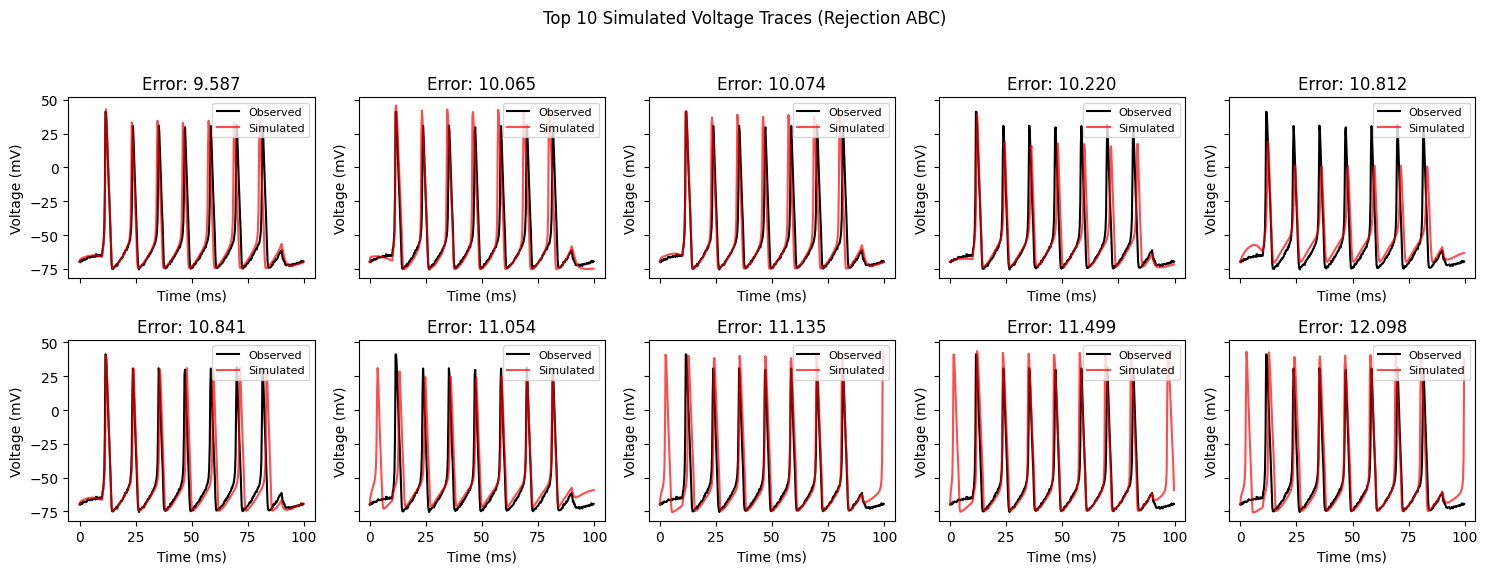

In [ ]:
# Plot the top 10 simulated voltage traces (from accepted samples) compared to the observed trace.
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()

for i, idx in enumerate(top_indices):
    sim_trace = accepted_v[idx]
    err_val = accepted_distances[idx]
    axes[i].plot(t_obs, v_obs, label="Observed", color="black")
    axes[i].plot(t_obs, sim_trace, label="Simulated", color="red", alpha=0.7)
    axes[i].set_title(f"Error: {err_val:.3f}")
    axes[i].set_xlabel("Time (ms)")
    axes[i].set_ylabel("Voltage (mV)")
    axes[i].legend(fontsize=8)

plt.suptitle("Top 10 Simulated Voltage Traces (Rejection ABC)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Rejection ABC (with features)
Rather than computing the distance on the raw voltage traces of the HH model, it can be beneficial to compute the distance on a lower dimensional representation of the data. This is computationally much easier and more robust. A common approach to reduce the dimensionality of the data is to compute so called summary features, which are able to capture more of the global structure of the data.

### Tasks
- Implement a distance metric based on summary features
    - How could you quantify global charecteristics of the voltage trace? Think of statistical properties.
    - Come up with your own summary features and implement them
- Run the rejection ABC sampler again with the new distance metric
- Plot your top 10 parameter samples. Compare them to the previous best samples
- Play around with the threshold to see how it affects the results

### Questions
- How do the results compare to the previous results? Which ones would you consider to be better?
- What are ways in which you could improve the results even further?

In [ ]:
def compute_summary_stats_np(v: jnp.ndarray) -> jnp.ndarray:
    """Compute summary statistics of the voltage trace.

    A feature can be anything that takes the time series as input and returns a single number.

    Args:
        v: The voltage trace. Can be a 1D array (timepoints) or 2D (samples, timepoints).

    Returns:
        summary_stats: If v is 1D, returns a 1D array of features.
                       If v is 2D, returns a 2D array of shape (samples, features).
    """
    if v.ndim == 1:
        ft1 = jnp.mean(v)
        ft2 = jnp.std(v)
        ft3 = jnp.max(v)
        ft4 = jnp.min(v)
        return jnp.hstack([ft1[None], ft2[None], ft3[None], ft4[None]])
    elif v.ndim == 2:
        ft1 = jnp.mean(v, axis=1)
        ft2 = jnp.std(v, axis=1)
        ft3 = jnp.max(v, axis=1)
        ft4 = jnp.min(v, axis=1)
        return jnp.stack([ft1, ft2, ft3, ft4], axis=1)

def fts_err(v_est: jnp.ndarray, v_true: jnp.ndarray) -> jnp.ndarray:
    """Compute a feature based distance.

    It computes summary features of the voltage traces and returns the sum of the absolute differences.

    Args:
        v_est: The estimated voltage trace (can be a batch of traces).
        v_true: The true voltage trace (1D array).

    Returns:
        ft_err: If v_est is a batch (2D), returns a 1D array with the error for each sample.
                Otherwise, returns a scalar error.
    """
    fts_est = compute_summary_stats_np(v_est)
    fts_true = compute_summary_stats_np(v_true)
    if fts_est.ndim == 2:
        return jnp.sum(jnp.abs(fts_est - fts_true), axis=1)
    else:
        return jnp.sum(jnp.abs(fts_est - fts_true))


In [ ]:
# Run rejection ABC using the new feature-based distance metric.
num_samples = 10_000
threshold = 25  # Adjust as needed based on your data
accepted_params, accepted_distances, accepted_v = rejection_abc(num_samples, threshold, fts_err)

# Sort accepted samples by distance (lowest error first)
sorted_indices = jnp.argsort(accepted_distances)
top_indices = sorted_indices[:10]  # Get top 10 best-fitting samples


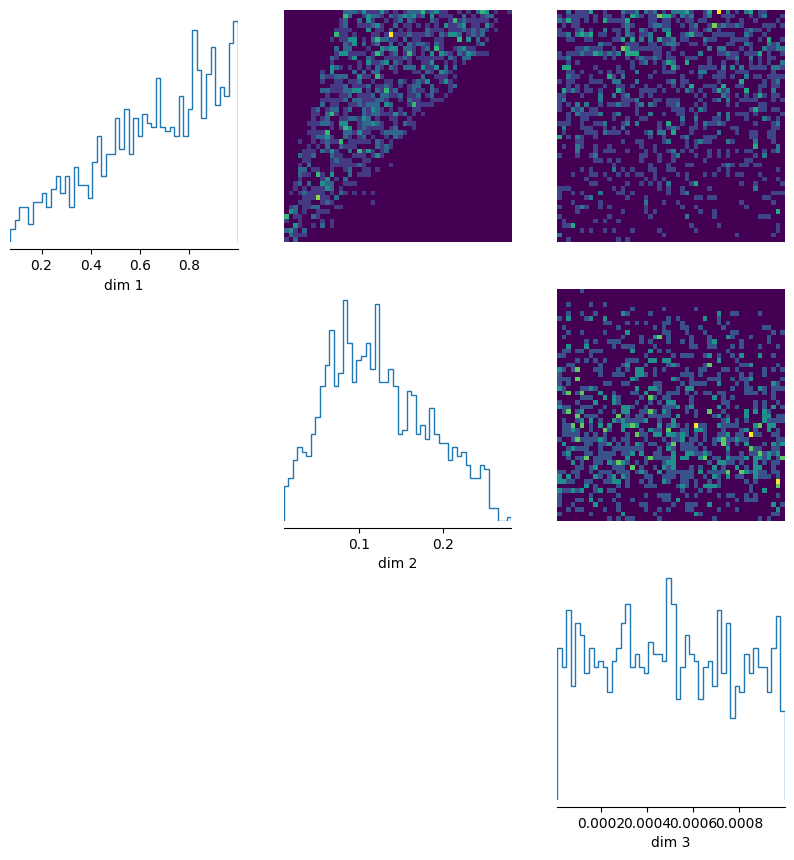

In [ ]:
import torch
import numpy as np
from sbi.analysis import pairplot

# Convert accepted parameter samples into a torch tensor for pairplot.
# Each column corresponds to one parameter.
accepted_samples = torch.tensor(np.array(list(accepted_params.values())).T)

# Visualize the estimated posterior over the parameters within the prior bounds.
pairplot(accepted_samples, var_names=list(accepted_params.keys()))
plt.show()

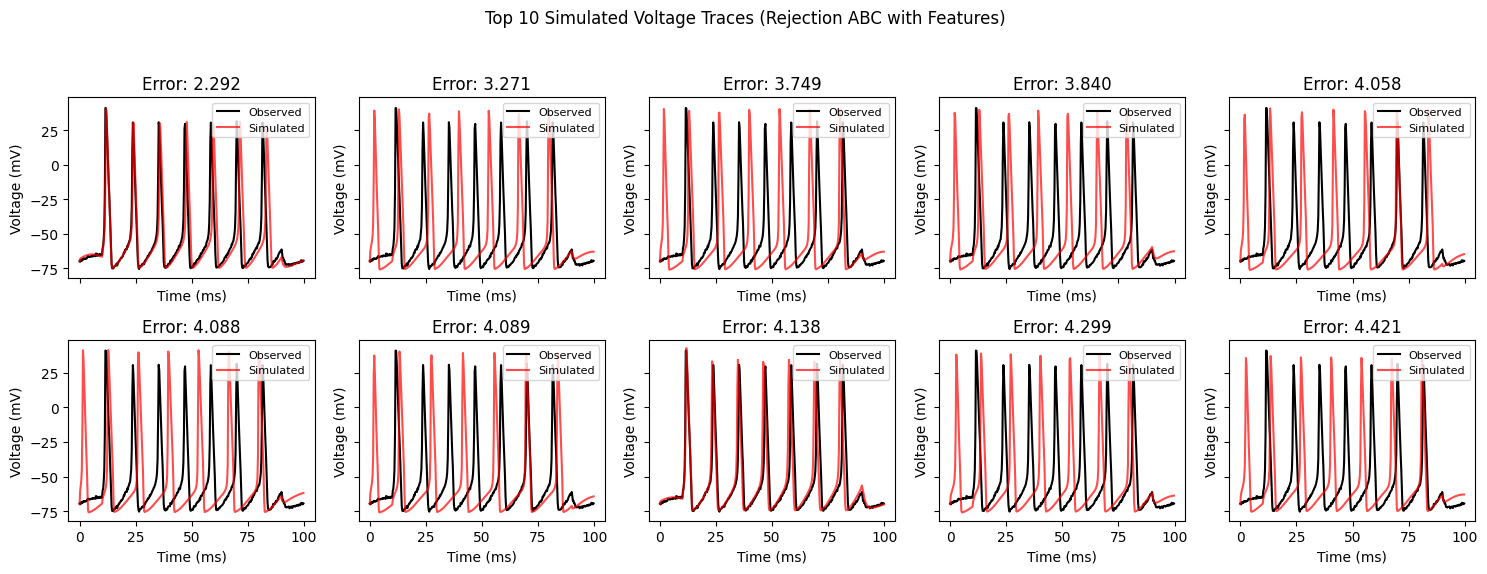

In [ ]:
# Plot the top 10 accepted simulated voltage traces against the observed trace.
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()

for i, idx in enumerate(top_indices):
    sim_trace = accepted_v[idx]
    err_val = accepted_distances[idx]
    axes[i].plot(t_obs, v_obs, label="Observed", color="black")
    axes[i].plot(t_obs, sim_trace, label="Simulated", color="red", alpha=0.7)
    axes[i].set_title(f"Error: {err_val:.3f}")
    axes[i].set_xlabel("Time (ms)")
    axes[i].set_ylabel("Voltage (mV)")
    axes[i].legend(fontsize=8)

plt.suptitle("Top 10 Simulated Voltage Traces (Rejection ABC with Features)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Neural Posterior Estimation

While rejection ABC provides a more principled approach than grid or random searches, it can become inefficient as the dimensionality of the parameter space increases or when the simulator is computationally expensive. Neural Posterior Estimation (NPE) addresses these limitations by using neural networks to learn an approximation of the posterior distribution directly from simulation data.

NPE leverages the power of conditional density estimation to build a model that maps from observed data to the corresponding posterior distribution over parameters. This approach often requires fewer simulations than traditional ABC methods and can capture complex posterior distributions more effectively.

### Tasks
- Implement NPE using the `sbi` package, use the lower dimensional summary features as input. For details see the [documentation](https://sbi-dev.github.io/sbi/0.22/)
    - Use one round of `SNPE` for that
    - use a MDN as a density estimator (run `?SNPE` for details)
    - reimplement the `compute_summary_stats` function to work with torch tensors
- plot the posterior
- compute the MAP estimate

### Questions
- Under what circumstances might NPE be preferable to rejection ABC, and vice versa?
- How do the posterior estimates from NPE compare to those from rejection ABC in terms of accuracy and efficiency?

_Note: the `sbi` package is based on pytorch and hence expects `torch.tensors` as inputs and outputs. These work similarly to numpy arrays and also come with similar functions, i.e `torch.sum` etc. Use the [documentation](https://sbi-dev.github.io/sbi/0.22/) to answer your questions._

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sbi.utils import BoxUniform
from sbi.inference import SNPE


# Define uniform prior for the parameters using bounds

prior = BoxUniform(
    low=torch.tensor([1e-3, 1e-3, 1e-5], dtype=torch.float32),
    high=torch.tensor([1.0, 1.0, 1e-3], dtype=torch.float32)
)

# Reimplement summary statistics function for torch tensors
def compute_summary_stats_torch(x: torch.Tensor) -> torch.Tensor:
    """Compute summary statistics of the voltage trace.

    Args:
        x: Voltage trace (torch tensor of shape [batch, timepoints] or [timepoints]).

    Returns:
        summary_stats: Tensor of shape [batch, 4] with [mean, std, max, min].
    """
    if x.ndim == 1:
        x = x.unsqueeze(0)  # Convert [timepoints] to [1, timepoints]
    ft1 = torch.mean(x, dim=1)
    ft2 = torch.std(x, dim=1)
    ft3 = torch.max(x, dim=1).values
    ft4 = torch.min(x, dim=1).values
    return torch.stack([ft1, ft2, ft3, ft4], dim=1)

# Simulator function compatible with sbi
def simulate_for_sbi(theta: torch.Tensor) -> torch.Tensor:
    """Simulate the Hodgkin-Huxley model for given parameters.

    Args:
        theta: Parameters (torch tensor of shape [batch, num_params]).

    Returns:
        v: Voltage traces (torch tensor of shape [batch, n_timepoints], downsampled to match v_obs).
    """
    theta_np = theta.numpy()
    theta_dict = {k: v for k, v in zip(["HH_gNa", "HH_gK", "HH_gLeak"], theta_np.T)}
    # Assuming parallel_simulate returns a jax array of shape [n_thetas, n_recordings, n_timepoints]
    v_sim = parallel_simulate(theta_dict)
    v_sim = torch.tensor(v_sim[:, 0, :], dtype=torch.float32)  # Extract first recording
    downsample_factor = v_sim.shape[1] // v_obs.shape[0]
    v_sim_ds = v_sim[:, ::downsample_factor]
    return v_sim_ds

In [ ]:
# Generate training data
theta_train = prior.sample((10000,))  # 10,000 samples from the prior
v_train = simulate_for_sbi(theta_train)
x_train = compute_summary_stats_torch(v_train)

# Prepare observed data
x_obs = compute_summary_stats_torch(torch.tensor(v_obs, dtype=torch.float32).unsqueeze(0))

# Run NPE with one round of SNPE using MDN
snpe = SNPE(prior=prior, density_estimator='mdn')
infer = snpe.append_simulations(theta_train, x_train)
estimator = infer.train()  # Train the density estimator
posterior = snpe.build_posterior(estimator)  # Build the posterior with the trained estimator

NameError: name 'prior' is not defined

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
# Sample from the posterior conditioned on observed data
samples = posterior.sample((10000,), x=x_obs)

# Plot the posterior using pairplot for the three parameters
param_names = ["HH_gNa", "HH_gK", "HH_gLeak"]
samples_np = samples.detach().numpy()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

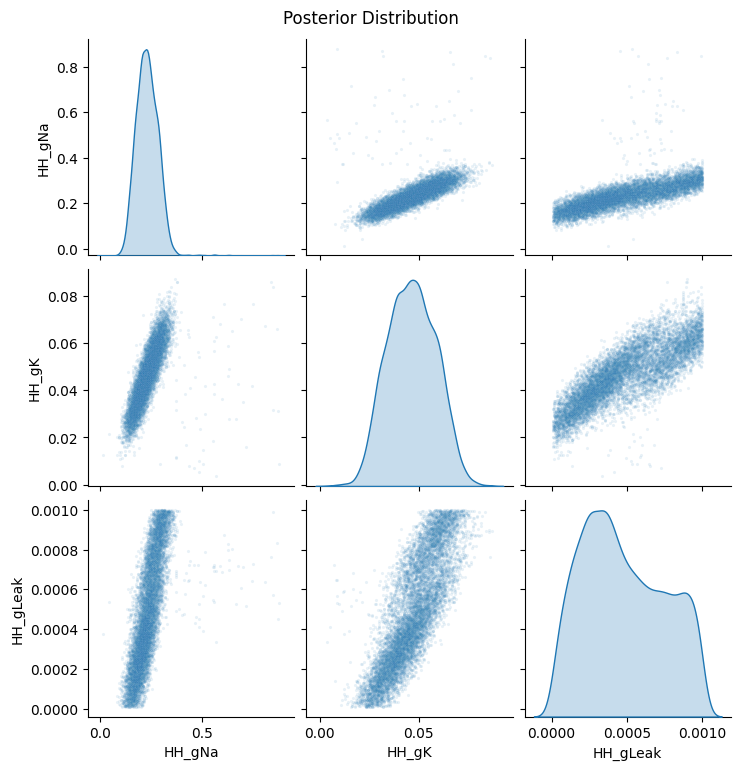

In [ ]:
sns.pairplot(
    data=pd.DataFrame(samples_np, columns=param_names),
    diag_kind="kde",
    plot_kws={"alpha": 0.1, "s": 5}
)
plt.suptitle("Posterior Distribution", y=1.02)
plt.show()

In [ ]:
# Compute log probabilities and MAP estimate
log_probs = posterior.log_prob(samples, x=x_obs)
theta_map = samples[torch.argmax(log_probs)]
print(f"MAP estimate: gNa={theta_map[0].item():.3f}, gK={theta_map[1].item():.3f}, gLeak={theta_map[2].item():.5f}")

# Simulate top 10 parameter sets (optional)
top_indices = torch.argsort(log_probs, descending=True)[:10]
theta_top = samples[top_indices]
v_top = simulate_for_sbi(theta_top)

MAP estimate: gNa=0.203, gK=0.040, gLeak=0.00029


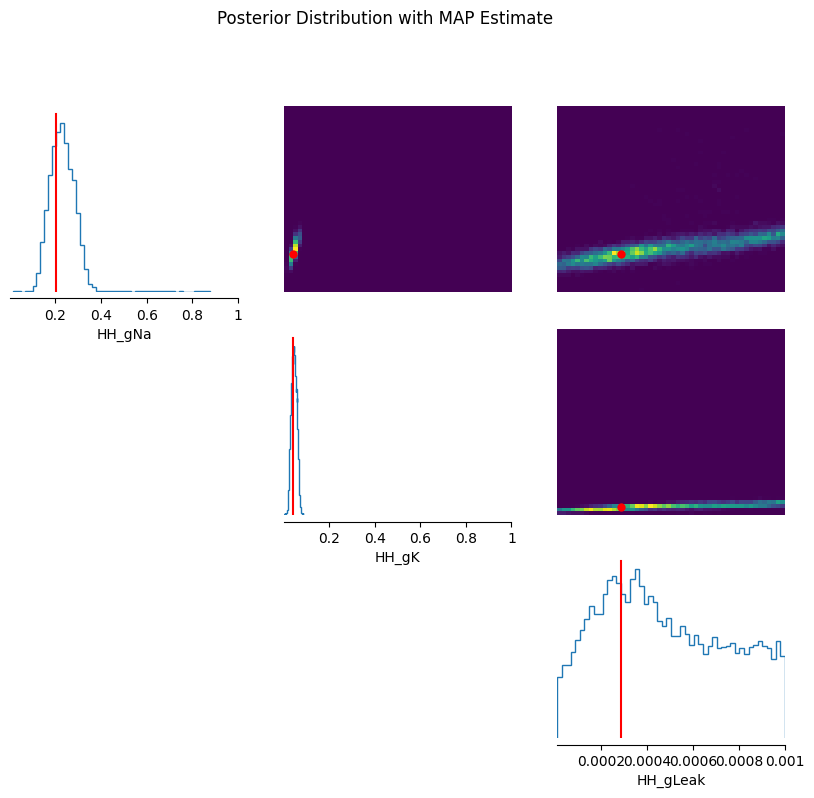

In [ ]:
from sbi.analysis import pairplot
import matplotlib.pyplot as plt

# Visualize the estimated posterior using pairplot.
pairplot(
    samples,  # Torch tensor of posterior samples
    points=theta_map.unsqueeze(0),  # MAP estimate reshaped to [1, 3] for overlay
    limits=[[1e-3, 1.0], [1e-3, 1.0], [1e-5, 1e-3]],  # Parameter bounds
    figsize=(10, 8),  # Figure size
    labels=["HH_gNa", "HH_gK", "HH_gLeak"],  # Consistent parameter names
    points_colors=["red"],  # Color for MAP points
    points_offdiag={"markersize": 10}  # Size of MAP points in off-diagonal plots
)

plt.suptitle("Posterior Distribution with MAP Estimate", y=1.02)  # Title with padding
plt.show()

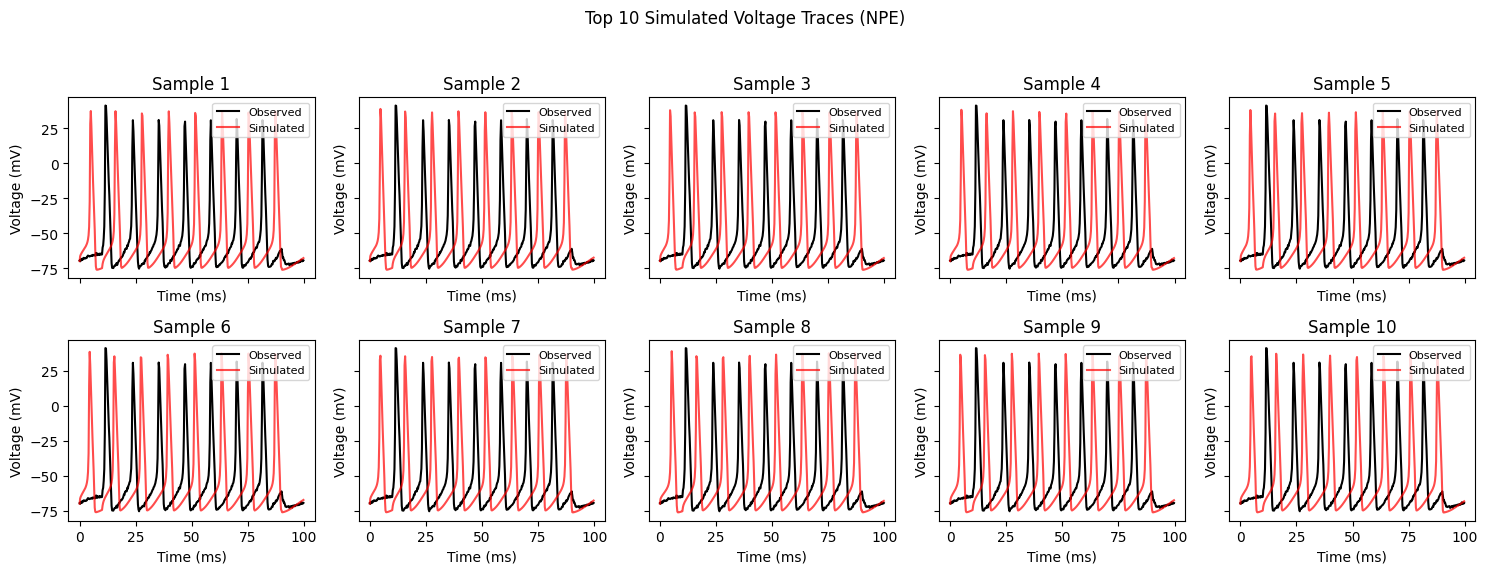

In [ ]:
# Plot the top 10 simulated voltage traces and compare them with the observed trace.
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(10):
    sim_trace = v_top[i].numpy()  # Convert torch tensor to NumPy array
    axes[i].plot(t_obs, v_obs, label="Observed", color="black")
    axes[i].plot(t_obs, sim_trace, label="Simulated", color="red", alpha=0.7)
    axes[i].set_title(f"Sample {i+1}")
    axes[i].set_xlabel("Time (ms)")
    axes[i].set_ylabel("Voltage (mV)")
    axes[i].legend(fontsize=8)

plt.suptitle("Top 10 Simulated Voltage Traces (NPE)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()

## Gradient Descent via Backpropagation of Error
While sampling-based methods like ABC and Neural Posterior Estimation provide distributional estimates of parameters, optimization approaches offer an alternative strategy when we primarily seek point estimates. This can be especially useful when the simulator is computationally expensive but gradients over the simulator parameters are available, since gradient-based optimization usually requires many fewer evaluations of the simulator compared to sampling-based methods.


### Tasks
- Optimize parameters directly on the time series data using gradient descent
- Bonus: Optimize using summary statistics as an alternative approach

### Questions
- How do the results compare to the ones from SBI methods?
- How do the results from the feature based approach compare to the ones from the mean squared error loss?
- What are ways to make the optimization process more robust to local minima?

_Note: to ensure that the parameters are optimized within their bounds, we use use sigmoid to transform between the interval [a,b] <-> [-inf,inf]. You can use the [documentation](https://jaxley.readthedocs.io/en/latest/index.html) and [tutorials](https://jaxley.readthedocs.io/en/latest/tutorials.html) to help you answer the questions._

In [ ]:
I will work on this later today.